In [1]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
from shapely.geometry import box

/tmp/ipykernel_5812/2968460828.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
boreal_tiles = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v003.gpkg')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<AxesSubplot:>

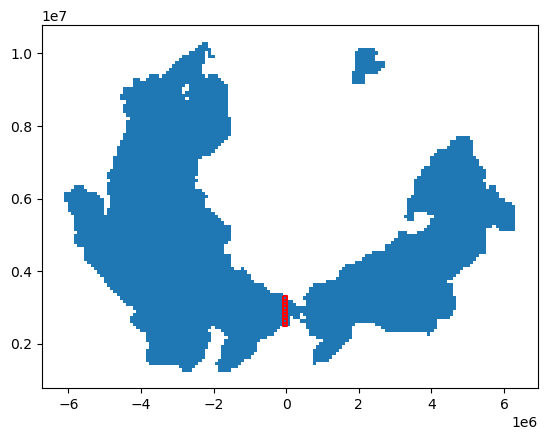

In [3]:
# dateline (bad) tiles
dateline_tiles = [3540,3634,3728,3823,3916,4004,41995,41807,41619]

ax = boreal_tiles.plot()
boreal_tiles[boreal_tiles['tile_num'].isin(dateline_tiles)].boundary.plot(ax=ax, ec='red')

<AxesSubplot:>

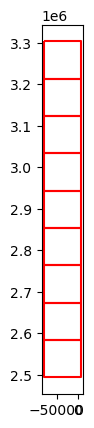

In [4]:
# Subset, removing datelines tiles
boreal_tiles_dateline = boreal_tiles[boreal_tiles['tile_num'].isin(dateline_tiles)]
boreal_tiles_dateline.boundary.plot(ec='red')

### Remove dateline tiles from original agg file

In [5]:
# Open previously generated 'aggregate' tiles vector
boreal_tiles_agg = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg10_bb_4326.gpkg').to_crs(boreal_tiles.crs)

<AxesSubplot:>

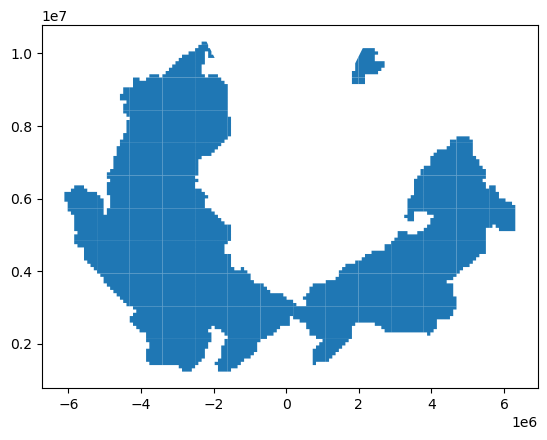

In [6]:
boreal_tiles_agg.plot()

<AxesSubplot:>

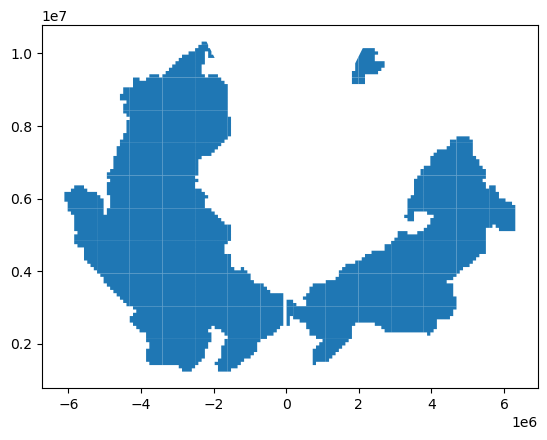

In [467]:
new_geometry = boreal_tiles_agg['geometry'].difference(boreal_tiles_dateline.unary_union)
new_geometry.plot()

In [468]:
boreal_tiles_agg_sub = gpd.GeoDataFrame(geometry=new_geometry)
boreal_tiles_agg_sub['agg_tile_num'] = boreal_tiles_agg_sub.index + 1

<AxesSubplot:>

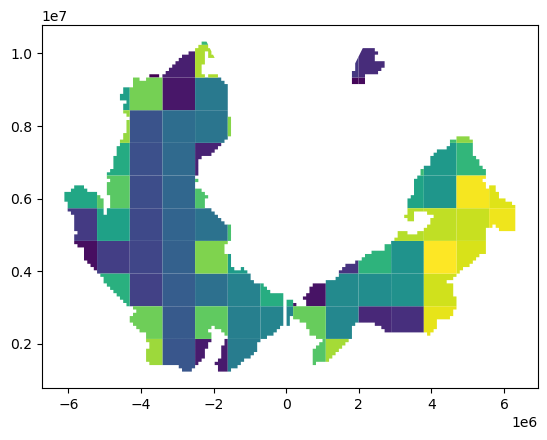

In [469]:
boreal_tiles_agg_sub.plot(column='agg_tile_num')

## Create final agg tile

In [8]:
length_m_boreal_tile = int(boreal_tiles.iloc[1].geometry.length/4)
length_m_boreal_tile

90000

In [49]:
# number of boreal tiles to aggregate
AGG_FACTOR = 9

In [50]:
# Get the extent of the shapefile
total_bounds = boreal_tiles.total_bounds
minX, minY, maxX, maxY = total_bounds

x, y = (minX, minY)
geom_array = []

square_size = length_m_boreal_tile * AGG_FACTOR

while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

In [51]:
boreal_tiles_agg_new = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(boreal_tiles.crs)
boreal_tiles_agg_new['agg_tile_num'] = boreal_tiles_agg_new.index + 1

<AxesSubplot:>

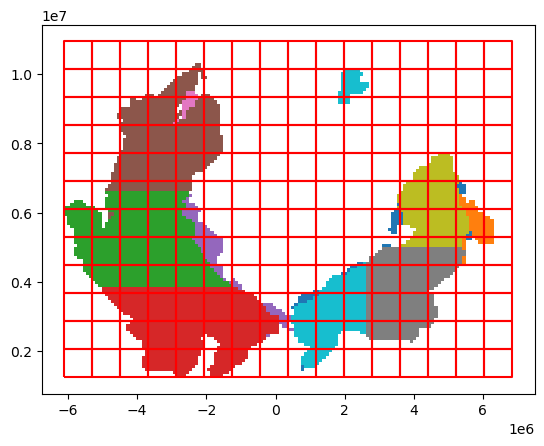

In [52]:
ax = boreal_tiles.plot(column='tile_group')
boreal_tiles_agg_new.boundary.plot(ax=ax, color='red')

## Spatial join, intersecting boreal agg tiles with boreal tiles 

### Clean up the dateline

In [53]:
agg_bounds = boreal_tiles_agg_new.total_bounds

In [54]:
dateline_tiles_box = list(boreal_tiles_dateline.total_bounds)
print(dateline_tiles_box)
dateline_tiles_box = [dateline_tiles_box[0] , agg_bounds[1], dateline_tiles_box[2], agg_bounds[3]] 
dateline_tiles_box

[-81478.00000000466, 2493304.0000000093, 8521.999999995343, 3303304.0000000093]


[-81478.00000000466, 1233304.0000000093, 8521.999999995343, 10953304.00000001]

<AxesSubplot:>

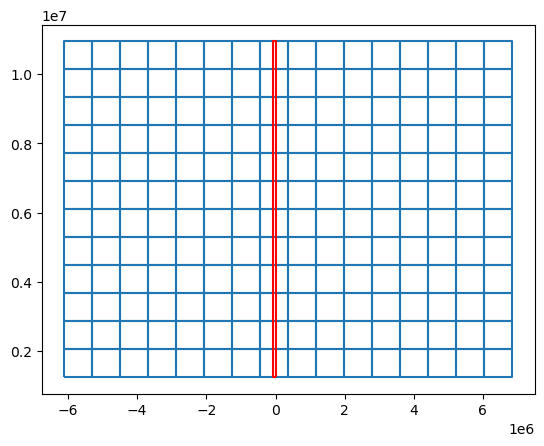

In [55]:
dateline_geom = shapely.geometry.box(*dateline_tiles_box)
dateline_geom_gdf = gpd.GeoDataFrame(crs = boreal_tiles.crs, geometry=[dateline_geom])
ax = boreal_tiles_agg_new.boundary.plot()
dateline_geom_gdf.boundary.plot(ax=ax, ec='red')

In [56]:
import numpy as np
import matplotlib.colors as mcolors

#### Make sure that each polygon is unique
explode

/tmp/ipykernel_5812/3979466279.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boreal_tiles_agg_new_sub = gpd.GeoDataFrame(geometry = new_geom, crs = boreal_tiles.crs).explode()
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

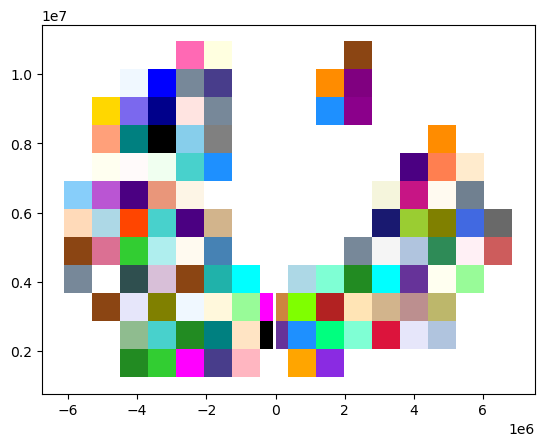

In [59]:
new_geom = gpd.sjoin(boreal_tiles_agg_new, boreal_tiles[['map_version','geometry']], predicate='intersects').dissolve('agg_tile_num').difference(dateline_geom_gdf.unary_union)
boreal_tiles_agg_new_sub = gpd.GeoDataFrame(geometry = new_geom, crs = boreal_tiles.crs).explode()

boreal_tiles_agg_new_sub.reset_index(inplace=True)
boreal_tiles_agg_new_sub['agg_tile_num'] = boreal_tiles_agg_new_sub.index + 1
boreal_tiles_agg_new_sub = boreal_tiles_agg_new_sub.reset_index(drop=True).drop(['level_1'], axis=1)
boreal_tiles_agg_new_sub.plot(column='agg_tile_num', color = [np.random.choice(list(mcolors.CSS4_COLORS.values())) for i in range(125)] )

In [60]:
boreal_tiles_agg_new_sub.head()

,agg_tile_num,geometry
0,1,"POLYGON ((-4491478.000 1233304.000, -4491478.0..."
1,2,"POLYGON ((-2871478.000 1233304.000, -3681478.0..."
2,3,"POLYGON ((-2061478.000 1233304.000, -2871478.0..."
3,4,"POLYGON ((-1251478.000 2043304.000, -1251478.0..."
4,5,"POLYGON ((-441478.000 2043304.000, -441478.000..."


In [61]:
# xmin, ymin, xmax, ymax = [int(x) for x in boreal_tiles_agg_new_sub.total_bounds]
# boreal_tiles_agg_new_sub = boreal_tiles_agg_new_sub.cx[xmin:xmax, ymin:ymax]

<AxesSubplot:>

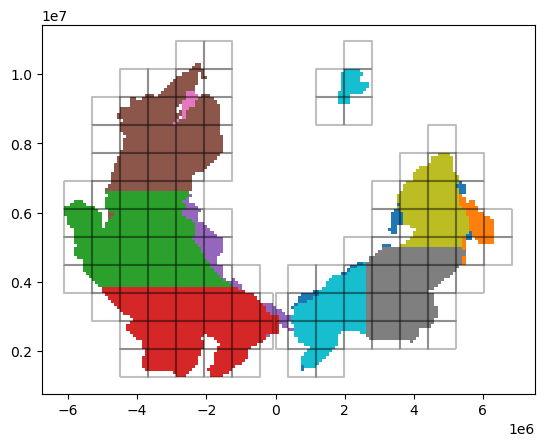

In [62]:
ax = boreal_tiles.plot(column='tile_group')
boreal_tiles_agg_new_sub.boundary.plot(ax=ax, ec='black', alpha = 0.25)

In [63]:
print(f"{len(boreal_tiles_agg_new_sub)} agg tiles you'll have to export from GEE for each year's seasonal composite")

110 agg tiles you'll have to export from GEE for each year's seasonal composite


## At AGG_FACTOR=20, polygons 19 and 24 extend too far north and fail to export in GEE

In [64]:

PROBLEM_TILES_LIST = [19,24,29,31]
EMPTY_TILES_LIST = []


if AGG_FACTOR==20:
    
    # These AGG tiles do not have boreal_tiles - remove
    EMPTY_TILES_LIST = [1,8]
    
    # Get AGG tiles with problems
    problem_tiles_gdf = boreal_tiles_agg_new_sub[boreal_tiles_agg_new_sub.agg_tile_num.isin(PROBLEM_TILES_LIST)]
    
    # Clip boreal tiles to extent of fix tiles
    boreal_tiles_clip_tmp = boreal_tiles.clip(problem_tiles_gdf)
    print(boreal_tiles_clip_tmp.total_bounds)
    
    # Plot to check
    ax = boreal_tiles_clip_tmp.plot(column='tile_group', ec='black')
    problem_tiles_gdf.boundary.plot(ax=ax, ec='black', alpha = 0.25)

    # Get bbox from clipped boreal_tiles
    new_box = list(boreal_tiles_clip_tmp.total_bounds)
    # ... actually get bboc from clipped boreal tiles + some more in the x direction
    new_box = [new_box[0] , new_box[1], new_box[2] + 2e5, new_box[3]] 
    print(new_box)
    
    # Make gdf of new box
    new_tiles_geom = shapely.geometry.box(*new_box)
    new_tiles_geom_gdf = gpd.GeoDataFrame(crs = boreal_tiles.crs, geometry=[new_tiles_geom])
    
    # Plot fix extent to check
    ax = boreal_tiles_clip_tmp.plot(column='tile_group', ec='black')
    ax = problem_tiles_gdf.boundary.plot(ax=ax, ec='black', alpha = 0.25)
    new_tiles_geom_gdf.boundary.plot(ax=ax, ec='red')
    
    # Clip fix tiles by new tiles gdf
    fixed_tiles_gdf = problem_tiles_gdf.clip(new_tiles_geom_gdf)
    
    

## Clean up AGG_TILE_NUM

In [65]:
if AGG_FACTOR==20:
    #fixed_tiles_gdf.reset_index(inplace=True)
    boreal_tiles_agg_new_sub_FIXED = pd.concat([fixed_tiles_gdf, boreal_tiles_agg_new_sub[~boreal_tiles_agg_new_sub.agg_tile_num.isin(PROBLEM_TILES_LIST + EMPTY_TILES_LIST)]])
    boreal_tiles_agg_new_sub_FIXED = boreal_tiles_agg_new_sub_FIXED.sort_values(by=['agg_tile_num'], ascending=True)
    boreal_tiles_agg_new_sub_FIXED.reset_index(inplace=True, drop=True)
    #boreal_tiles_agg_new_sub_FIXED.reset_index(inplace=True)
    #boreal_tiles_agg_new_sub_FIXED.drop('index', inplace=True)
    boreal_tiles_agg_new_sub_FIXED['agg_tile_num'] = boreal_tiles_agg_new_sub_FIXED.index + 1

    boreal_tiles_agg_new_sub_FIXED.tail()
    
    OUT_TILES_GDF = boreal_tiles_agg_new_sub_FIXED

else:
    
    OUT_TILES_GDF = boreal_tiles_agg_new_sub

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

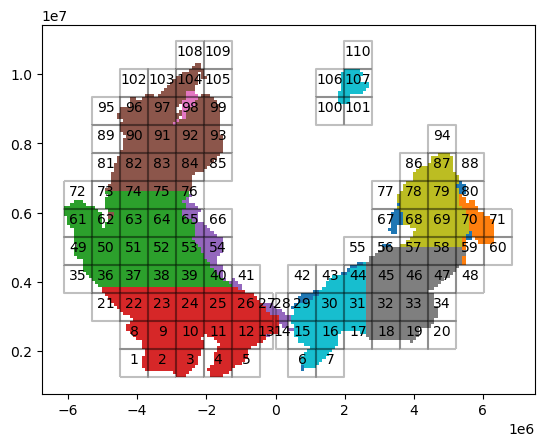

In [67]:
ax = boreal_tiles.plot(column='tile_group')


if True:
    tmp = OUT_TILES_GDF.copy()
    tmp.boundary.plot(ax=ax, ec='black', alpha = 0.25)
    
    tmp['coords'] = tmp['geometry'].apply(lambda x: x.representative_point().coords[:])
    tmp['coords'] = [coords[0] for coords in tmp['coords']]

    for idx, row in tmp.iterrows():
        plt.annotate(text=row['agg_tile_num'], xy=row['coords'],horizontalalignment='center')
        


In [68]:
OUT_TILES_GDF.columns

Index(['agg_tile_num', 'geometry'], dtype='object')

In [70]:
# OUT_TILES_GDF = OUT_TILES_GDF.drop(['coords'])
# OUT_TILES_GDF.info()

In [71]:
OUT_TILES_GDF.to_crs(4326).to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}/boreal_tiles_v003_agg{AGG_FACTOR}_4326.shp' )
#OUT_TILES_GDF.to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}.shp' )
OUT_TILES_GDF.to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}/boreal_tiles_v003_agg{AGG_FACTOR}.gpkg' )

/tmp/ipykernel_5812/302673084.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  OUT_TILES_GDF.to_crs(4326).to_file(f'/projects/shared-buckets/montesano/databank/boreal_tiles_v003_agg{AGG_FACTOR}_4326.shp' )
